# Recurrent Neural Networkd

In this Lab we learn how to solve sequential problems using RNNs. We will describe how can RNNs be implemented with PyTorch and evaluate their results in real problems.

## Imports

In [4]:
import numpy as np
import numpy.random as rnd
import itertools 
import os
import sys
import scipy.misc
import random

# We used some utilities from sklearn
from sklearn.preprocessing import StandardScaler

#PyTorch
import torch
from torch import nn
from torch.optim import Adam, SGD
from torchsummary import summary
from torch.autograd  import Variable

# Used for plotting and display of figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


from IPython.display import display
from IPython.display import Image
from IPython.display import SVG

The first problem we consider is time series prediction with an RNN. Given a sequence of k contiguous points of the time series, $(t_{r},t_{r+1},\dots,t_{r+k})$ that are used as inputs, we will try to predict the sequence $(t_{r+1},t_{r+2},\dots,t_{r+k+1})$. Therefore, for each single point at time $t$, the target variable is the time series value at time $t+1$.

## Time Series Example

In [5]:
# The function belows generates a particular time series.
def time_series(t):
    return t * np.sin(t) / 3 + 2 * np.sin(t*5)

To train the network we need sequences of size $k$ extracted from the time series. They are randomly selected using the function "next_batch" that outputs a set of <batch_size> training points, each point corresponding to a sequence of size k (in the function this size k is called "n_steps"). 

In [6]:
t_min, t_max = 0, 30
resolution = 0.1

# Receives the number of samples (batch_size) of size (n_steps) to extract
# from the time series, and outputs such a sample
def next_batch(batch_size, n_steps):
    t0 = np.random.rand(batch_size, 1) * (t_max - t_min - n_steps * resolution)
    Ts = t0 + np.arange(0., n_steps + 1) * resolution
    ys = time_series(Ts)
    return ys[:, :-1].reshape(-1, n_steps, 1), ys[:, 1:].reshape(-1, n_steps, 1)

In the next cell, we visualize the time series, and an example of training pairs $(x,y)$, where $x$ is a sequence of $k=20$ points and $y$ is the target sequence of $20$ points, the ones obtained by shifting $x$ only one position. 



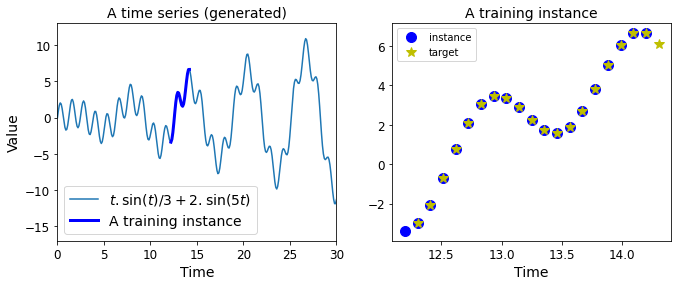

In [7]:
# The time series and the example of (x,y) are shown 

t = np.linspace(t_min, t_max, int((t_max - t_min) / resolution))

n_steps = 20
t_instance = np.linspace(12.2, 12.2 + resolution * (n_steps + 1), n_steps + 1)

plt.figure(figsize=(11,4))
plt.subplot(121)
plt.title("A time series (generated)", fontsize=14)
plt.plot(t, time_series(t), label=r"$t . \sin(t) / 3 + 2 . \sin(5t)$")
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "b-", linewidth=3, label="A training instance")
plt.legend(loc="lower left", fontsize=14)
plt.axis([0, 30, -17, 13])
plt.xlabel("Time")
plt.ylabel("Value")

plt.subplot(122)
plt.title("A training instance", fontsize=14)
plt.plot(t_instance[:-1], time_series(t_instance[:-1]), "bo", markersize=10, label="instance")
plt.plot(t_instance[1:], time_series(t_instance[1:]), "y*", markersize=10, label="target")
plt.legend(loc="upper left")
plt.xlabel("Time")


#save_fig("time_series_plot")
plt.show()

In [8]:
import pandas as pd
import seaborn as sns

df = pd.read_csv('data_akbilgic.csv')
df

,date,ISE,ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
0,5-Jan-09,0.035754,0.038376,-0.004679,0.002193,0.003894,0.000000,0.031190,0.012698,0.028524
1,6-Jan-09,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.018920,0.011341,0.008773
2,7-Jan-09,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
3,8-Jan-09,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
4,9-Jan-09,0.009860,0.009658,-0.021533,-0.019873,-0.012710,-0.004474,-0.009764,-0.010989,-0.007802
...,...,...,...,...,...,...,...,...,...,...
531,16-Feb-11,0.008599,0.013400,0.006238,0.001925,0.007952,0.005717,0.018371,0.006975,0.003039
532,17-Feb-11,0.009310,0.015977,0.003071,-0.001186,0.000345,0.002620,0.001686,-0.000581,0.001039
533,18-Feb-11,0.000191,-0.001653,0.001923,0.002872,-0.000723,0.000568,0.005628,0.000572,0.006938
534,21-Feb-11,-0.013069,-0.013706,-0.020742,-0.014239,-0.011275,0.001358,-0.011942,-0.012615,-0.000958


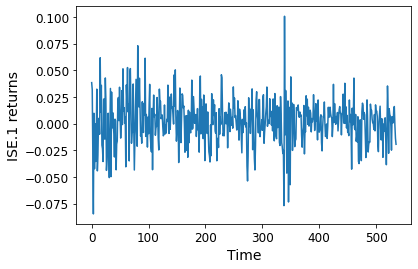

In [9]:
plt.plot(df['ISE.1'])
plt.xlabel("Time")
plt.ylabel("ISE.1 returns")
plt.show()

## Train/Test Split

Implement a train test split function without using sklearn

In [10]:
df_size = df.shape[1]
df_train = 0
df_test = 0

In [11]:
df_size

10

## Batchify the Data

Below you will need to implement a fucntion that returns a a batch to feed the RNN

In [14]:
# Receives the number of samples (batch_size) of size (n_steps) to extract
# from the time series, and outputs such a sample
def next_stock_batch(batch_size, n_steps, df_base):
    t_min = 0
    t_max = df_base.shape[0]

    feats = df_base.iloc[:, -8:].values
    random_seeds = np.random.randint(0, len(df_base)-n_steps-1, batch_size)

    x = []
    y = []
    for i in random_seeds:
        sequence = df_base.iloc[i:i+n_steps-1, -8:]
        target = df_base.iloc[i+1:i+n_steps, -1]

        x.append(sequence), y.append(target)



    # # The inputs will be formed by 8 sequences taken from
    # # 7 time series [ISE.1,SP,DAX,FTSE,NIKKEI,BOVESPA,EU]
    # x = np.zeros((batch_size,n_steps,7))
    #
    # # We want to predict the returns of the Istambul stock
    # # taken into consideration the previous n_steps days
    # y = np.zeros((batch_size,n_steps,1))
    #
    # # We chose batch_size random points from time series x-axis
    #
    # starting_points = np.random.randint(0,t_max-n_steps-1,size=batch_size)
    # #print(starting_points)
    #
    # # We create the batches for x using all time series (8) between t and t+n_steps
    # # We create the batches for y using only one time series between t+1 and t+n_steps+1
    #
    # #Save on x and y the time series data sequence and the prediction sequence

    return np.array(x), np.array(y)

In [16]:
x, y = next_stock_batch(5, 2, df)
print(x)
print('------')
print(y)

[[[-0.00928196 -0.00038275  0.00426951  0.00617103  0.00546014
    0.00296182  0.00639321  0.01028235]]

 [[-0.00437412  0.00391515  0.00289275  0.00214684  0.02815179
   -0.00534331 -0.00112841  0.00416555]]

 [[ 0.00587831 -0.00055609  0.00256511  0.0038448   0.01796687
    0.00478355  0.00098903  0.00333261]]

 [[ 0.00640804 -0.02052474 -0.01319186 -0.00672284 -0.00108438
   -0.01614313 -0.01319209 -0.00673086]]

 [[-0.01453262  0.01091624 -0.0061834  -0.00812111  0.00179865
    0.01093973 -0.00812487  0.00072363]]]
------
[[ 0.02309241]
 [ 0.0031282 ]
 [ 0.00260637]
 [-0.03856446]
 [ 0.0017334 ]]


## Parameters
Now we need to define the parameters of our RNN

In [ ]:
# An RNN can take as inputs multiple input sequences (e.g, a matrix of n_seq x n_steps)
# Since we use only a single TS, n_inputs=1
n_inputs = 7


# n_steps is the size of the contiguous sequence that is taken from the TS
# it coincides with the number of time steps for the RNN
n_steps = 5

# An RNN can take as inputs multiple input sequences (e.g, a matrix of n_seq x n_steps)
n_inputs = 7

# There is one layer of X recurrent neurons together
n_neurons = 2

# The ouput will be a single sequence
n_outputs = 1

## Architecture

In the next cell we will define our RNN architecture. For this example we will use a default torch architecture.

In [ ]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, n_steps):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.hidden = [0]
        #Defining the layers
        # RNN Layer
        
        self.rnn = nn.RNN(input_size, n_outputs, n_layers, batch_first=True)   
    
    def forward(self, x):
        
        # complete the forward function so it returns the output and the last hidden state
        # what is the input of an RNN?
        if len(self.hidden) == 1:
            #inicitialize at 0 values
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        return hidden

## Optimizer and Loss Function

The loss functio will comput the gradients and the optimizer will apply them. In the following cell we will need to initialize our model and create the optimizer and the loss function. Select the ones that you think are most suited for the task.

In [ ]:
# We initialize our RNN model to pass it to the optimizer

model = 

# What would be an adecuate loss function?
criterion =  # Criterion == Loss == Cost

# optimizer to apply the gradients
optim = 



## Trainning Loop

We will define the training loop for our model. This training loop is a little different than the usual. A normal training loop is epoch based meaning that it trains for a certain ammount of epochs seeing the whole dataset in each epoch. For this model we will use an 'online' training which mean we will generate the batches the moment before feeding it with no real regard for running trhough the entire dataset.

In [ ]:
#number of batches we will go through
n_iterations = 
#how many squence there will be in a bacth
batch_size = 
#after how many operations we will print information
printing_gap = 

#We will store the loss values here to plot them
train_loss = []


train_loss = []
for iter in range(n_iterations):
    #Get a batch

    #make into tensor

    #make them into torch variables in float format

    #Reset the gradients
    
    #Get the outputs

    #detach the hidden state
    
    #compute the loss

    #compute the gradients

    #Apply the gradients


    #Append the loss value
    train_loss.append()

    if iter % printing_gap == 0:
        #Print the information


plt.plot(train_loss, label= "Train Loss")
plt.xlabel(" Iteration ")
plt.ylabel("Loss value")
plt.legend(loc="upper left")
plt.show()




## Testing

Without updating or computing the gradients test the model in a single test batch

In [ ]:
#

# Visualization

In the following cell we will plot the y_true with out prediction

In [ ]:
 #Print the ground truth sequence and the predicted sequence of a batch in train

In [ ]:
 #Print the ground truth sequence and the predicted sequence of a batch in test

# Extra exercises

## 1. In the previous model we used a standard RNN cell but there are better option out there try them
## 2. Add dropout and batch normalization to a more complex model using another type of cell
## 3. Create a more shopisticated model that includes at least another linear layer
## 4. Create a new trainning loop in which you validate every X batches and you save the model with better validation result
